In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
device

device(type='cpu')

In [6]:
data = pd.read_csv('/content/drive/MyDrive/FISA A2/STOCK_INDEX.csv')

In [7]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0
1,2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0
2,2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0
3,2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0
4,2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0


In [8]:
data_valid = data.dropna()

In [9]:
data_valid

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0.0
1,2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0.0
2,2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0.0
3,2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0.0
4,2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0.0
...,...,...,...,...,...,...,...
2689,2021-04-26,14449.450200,14557.500000,14421.299810,14485.000000,14485.000000,452700.0
2690,2021-04-27,14493.799810,14667.549810,14484.849610,14653.049810,14653.049810,451800.0
2691,2021-04-28,14710.500000,14890.250000,14694.950200,14864.549810,14864.549810,457000.0
2692,2021-04-29,14979.000000,15044.349610,14814.450200,14894.900390,14894.900390,517500.0


In [10]:
data_valid_close = data_valid.reset_index()['Close']

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))

In [12]:
data_valid_close = scaler.fit_transform(np.array(data_valid_close).reshape(-1,1))

In [13]:
joblib.dump(scaler, '/content/drive/MyDrive/FISA A2/scaler.gz')

['/content/drive/MyDrive/FISA A2/scaler.gz']

In [14]:
num_training_samples = int(len(data_valid_close)*0.8)
num_testing_samples = len(data_valid_close) - num_training_samples

In [15]:
num_training_samples,num_testing_samples

(2133, 534)

In [16]:
data_valid_close = np.array(data_valid_close).reshape(-1,1)

In [17]:
past_data_length = 50
prediction_data_length = 2

In [18]:

timeseries = []
prediction = []
for i in range(len(data_valid_close)-(past_data_length+prediction_data_length)+1):
    data = data_valid_close[i:i+(past_data_length+prediction_data_length)]
    x = data[:past_data_length]
    y = data[past_data_length:]
    timeseries.append(x)
    prediction.append(y)
X = np.stack(timeseries)
Y = np.stack(prediction)

In [19]:
X.shape,Y.shape

((2616, 50, 1), (2616, 2, 1))

In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((2092, 50, 1), (2092, 2, 1), (524, 50, 1), (524, 2, 1))

In [22]:
X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).float()
X_val = torch.from_numpy(X_val).float()
Y_val = torch.from_numpy(Y_val).float()

In [23]:
X_train.dtype

torch.float32

In [24]:
training_dataset = torch.utils.data.TensorDataset(X_train,Y_train)
validation_dataset = torch.utils.data.TensorDataset(X_val,Y_val)

In [25]:
trainloader = torch.utils.data.DataLoader(training_dataset,batch_size = 1046,shuffle = True,collate_fn = torch.utils.data.default_collate , num_workers = 2)
validationloader = torch.utils.data.DataLoader(validation_dataset,batch_size = 100,shuffle = True,collate_fn = torch.utils.data.default_collate , num_workers = 2)

In [26]:
class LSTMmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.GRU(input_size=1, hidden_size=16, num_layers=2, batch_first=True, bidirectional = True)
        self.linear1 = nn.Linear(32, 16)
        self.linear2 = nn.Linear(16, 2)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear1(x[:,-1,:])
        x = self.linear2(x)
        return x

In [27]:
model = LSTMmodel()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-3,amsgrad=True)#weight_decay= 0.0005)
loss_fn = nn.MSELoss()
epochs = 2000

In [ ]:
model.to(device)

LSTMmodel(
  (lstm): GRU(1, 16, num_layers=2, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=32, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
train_loss_list = []
validation_loss_list = []
prev_validation_loss = 0
for epoch in tqdm(range(epochs)):
    model.train()
    training_loss = 0
    validation_loss = 0

    for i,(X_batch,Y_batch) in enumerate(trainloader):
        Y_pred = model(X_batch.to(device))
        loss = loss_fn(Y_pred,torch.squeeze(Y_batch.to(device)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.detach().cpu().numpy()
    training_loss = training_loss/len(trainloader)
    train_loss_list.append(training_loss)
    model.eval()
    with torch.no_grad():
        for i,(X_batch,Y_batch) in enumerate(validationloader):
            Y_pred = model(X_batch.to(device))
            loss = loss_fn(Y_pred,torch.squeeze(Y_batch.to(device)))
            validation_loss += loss.detach().cpu().numpy()
    validation_loss = validation_loss/len(validationloader)
    validation_loss_list.append(validation_loss)
    if validation_loss < prev_validation_loss :
      torch.save(model.state_dict(),"/content/drive/MyDrive/FISA A2/best_model_GRU_bidirectional_2linear_layer_no_skip_connection")
      prev_validation_loss = validation_loss
    if epoch%100 == 0:
      print("epoch: {} | training loss: {} | validation loss: {}".format(epoch+1,training_loss,validation_loss))

train_loss_list = np.array(train_loss_list)
validation_loss_list = np.array(validation_loss_list)


  0%|          | 1/2000 [00:01<43:41,  1.31s/it]

epoch: 1 | training loss: 0.24577517062425613 | validation loss: 0.22477282087008157


  5%|▌         | 101/2000 [01:49<31:58,  1.01s/it]

epoch: 101 | training loss: 0.00027271942235529423 | validation loss: 0.00022998218628345057


 10%|█         | 201/2000 [03:40<33:14,  1.11s/it]

epoch: 201 | training loss: 0.00021559571177931502 | validation loss: 0.00019219138145369166


 15%|█▌        | 301/2000 [05:56<36:38,  1.29s/it]

epoch: 301 | training loss: 0.00019066259847022593 | validation loss: 0.0001808281037180374


 20%|██        | 401/2000 [07:53<28:33,  1.07s/it]

epoch: 401 | training loss: 0.0001752648313413374 | validation loss: 0.0001587909161268423


 25%|██▌       | 501/2000 [09:50<32:11,  1.29s/it]

epoch: 501 | training loss: 0.00016519081691512838 | validation loss: 0.0001790669496889071


 30%|███       | 601/2000 [11:47<29:33,  1.27s/it]

epoch: 601 | training loss: 0.00015707145939813927 | validation loss: 0.00014328012912301347


 35%|███▌      | 701/2000 [13:45<24:14,  1.12s/it]

epoch: 701 | training loss: 0.00015133088163565844 | validation loss: 0.0001349351902414734


 40%|████      | 801/2000 [15:45<25:48,  1.29s/it]

epoch: 801 | training loss: 0.00014677482249680907 | validation loss: 0.0001397153719153721


 45%|████▌     | 901/2000 [17:55<23:01,  1.26s/it]

epoch: 901 | training loss: 0.00014300464681582525 | validation loss: 0.00013451526562372843


 50%|█████     | 1001/2000 [19:57<19:49,  1.19s/it]

epoch: 1001 | training loss: 0.0001400285545969382 | validation loss: 0.000124043279356556


 55%|█████▌    | 1101/2000 [22:03<19:10,  1.28s/it]

epoch: 1101 | training loss: 0.00013751981168752536 | validation loss: 0.00013662227866007015


 60%|██████    | 1201/2000 [24:09<18:05,  1.36s/it]

epoch: 1201 | training loss: 0.00013555583427660167 | validation loss: 0.00012694373314540522


 65%|██████▌   | 1301/2000 [26:39<18:49,  1.62s/it]

epoch: 1301 | training loss: 0.0001337627472821623 | validation loss: 0.00012048342250636779


 70%|███████   | 1401/2000 [28:47<12:47,  1.28s/it]

epoch: 1401 | training loss: 0.00013218552339822054 | validation loss: 0.00012287224065706445


 75%|███████▌  | 1501/2000 [30:56<10:26,  1.26s/it]

epoch: 1501 | training loss: 0.0001310181905864738 | validation loss: 0.00013751130245509557


 80%|████████  | 1601/2000 [33:05<08:33,  1.29s/it]

epoch: 1601 | training loss: 0.0001302813798247371 | validation loss: 0.00012213906666147523


 85%|████████▌ | 1701/2000 [35:16<06:18,  1.26s/it]

epoch: 1701 | training loss: 0.0001291983644478023 | validation loss: 0.00011826041372842155


 90%|█████████ | 1801/2000 [37:35<04:06,  1.24s/it]

epoch: 1801 | training loss: 0.00012847312609665096 | validation loss: 0.00011948645017885913


 95%|█████████▌| 1901/2000 [39:49<02:22,  1.44s/it]

epoch: 1901 | training loss: 0.0001278554627788253 | validation loss: 0.00012771769130874114


100%|██████████| 2000/2000 [42:02<00:00,  1.26s/it]


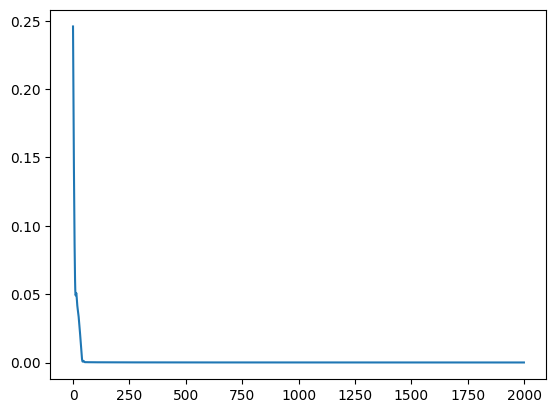

In [ ]:
plt.plot(train_loss_list)

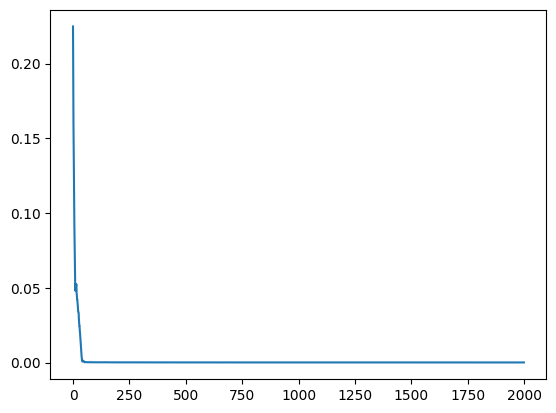

In [ ]:
plt.plot(validation_loss_list)